In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

### Import data into tensorflow dataset object
##### We will use image_dataset_from_directory api to load all images in tensorflow dataset: 

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 1 2 2 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 2 1 0 1 1 1 0 0 2 0 0 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    

[[[145. 144. 152.]
  [163. 162. 170.]
  [153. 152. 160.]
  ...
  [180. 183. 192.]
  [181. 184. 193.]
  [185. 188. 197.]]

 [[143. 142. 150.]
  [147. 146. 154.]
  [186. 185. 193.]
  ...
  [179. 182. 191.]
  [178. 181. 190.]
  [180. 183. 192.]]

 [[146. 145. 153.]
  [140. 139. 147.]
  [150. 149. 157.]
  ...
  [176. 179. 188.]
  [174. 177. 186.]
  [176. 179. 188.]]

 ...

 [[139. 137. 150.]
  [152. 150. 163.]
  [181. 179. 192.]
  ...
  [157. 160. 169.]
  [153. 156. 165.]
  [151. 154. 163.]]

 [[133. 131. 145.]
  [116. 114. 128.]
  [132. 130. 144.]
  ...
  [166. 169. 178.]
  [169. 172. 181.]
  [171. 174. 183.]]

 [[150. 148. 162.]
  [139. 137. 151.]
  [165. 163. 177.]
  ...
  [161. 164. 173.]
  [167. 170. 179.]
  [172. 175. 184.]]]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


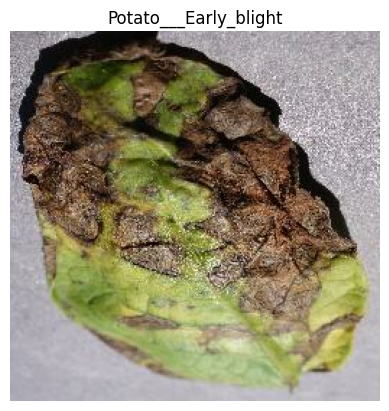

In [9]:
# Visualise 1 image
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8")) # original data in float, converted it into uint8 type
    plt.title(class_names[label_batch[0]]) #display classname
    plt.axis("off") # not showing the axis

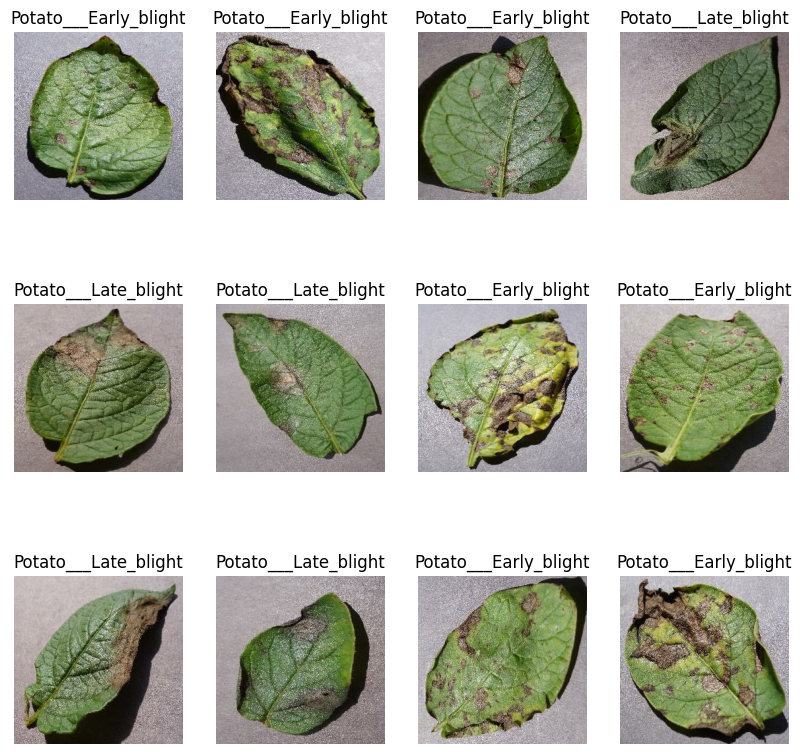

In [10]:
# Visualise multiple images in subplots
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # original data in float, converted it into uint8 type
        plt.title(class_names[label_batch[i]]) #display classname
        plt.axis("off") # not showing the axis


In [11]:
# Split Dataset
# 80% training
# 20% => validation 10%, testing = 10%

In [12]:
len(dataset)

68

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)

In [15]:
test_ds  = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions(ds, train_split = 0.80, val_split = 0.10, test_split = 0.10, shuffle = True, shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 13)
        
    train_size = int(ds_size*train_split)
    train_ds = ds.take(train_size)

    val_size = int(ds_size*val_split)
    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset
#### caching and prefetch (If i use CPU + GPU and when GPU is busy traiing, CPU can prefetch the data)

In [24]:
# tf.data.AUTOTUNE mean tensorflow will determine itself the batchsize
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Data Preprocessing

#### Resizing + Scaling

In [25]:
# resize and scale layer, it will take care of that situation such as any prediction image is out of the train image size
# then it will automatically resize and scale it so that best performace comes from the model.
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

#### Data Augmentation



##### Augmentation means rotating images, add contrast, zooming flipping and create more sample images from one image this increases the robustness of the model.

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Building

In [27]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape), # convulational layer
    layers.MaxPooling2D((2,2)), # maxpooling layer
    layers.Conv2D(64, (3,3), activation = "relu", input_shape = input_shape), # convulational layer
    layers.MaxPooling2D((2,2)), # maxpooling layer
    layers.Conv2D(64, (3,3), activation = "relu", input_shape = input_shape), # convulational layer
    layers.MaxPooling2D((2,2)), # maxpooling layer
    layers.Conv2D(64, (3,3), activation = "relu", input_shape = input_shape), # convulational layer
    layers.MaxPooling2D((2,2)), # maxpooling layer
    layers.Conv2D(64, (3,3), activation = "relu", input_shape = input_shape), # convulational layer
    layers.MaxPooling2D((2,2)), # maxpooling layer
    layers.Conv2D(64, (3,3), activation = "relu", input_shape = input_shape), # convulational layer
    layers.MaxPooling2D((2,2)), # maxpooling layer
    layers.Flatten(), # Flatten layer
    layers.Dense(64, activation = "relu"), # Dense layer
    layers.Dense(n_classes,activation="softmax"),
])

model.build(input_shape = input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
)

Epoch 1/50


54/54 [==============================] - 57s 944ms/step - loss: 0.9161 - accuracy: 0.4765 - val_loss: 0.9367 - val_accuracy: 0.4167
Epoch 2/50
54/54 [==============================] - 55s 1s/step - loss: 0.7356 - accuracy: 0.6197 - val_loss: 0.4487 - val_accuracy: 0.8385
Epoch 3/50
54/54 [==============================] - 57s 1s/step - loss: 0.4238 - accuracy: 0.8415 - val_loss: 0.3932 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 54s 999ms/step - loss: 0.3012 - accuracy: 0.8826 - val_loss: 0.2172 - val_accuracy: 0.9219
Epoch 5/50
54/54 [==============================] - 54s 1s/step - loss: 0.2898 - accuracy: 0.8832 - val_loss: 0.1907 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 54s 1s/step - loss: 0.2313 - accuracy: 0.9137 - val_loss: 0.1906 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 54s 999ms/step - loss: 0.2240 - accuracy: 0.9131 - val_loss: 0.2106 - val_accuracy: 0.9219
Epoch 8/5

In [31]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 220ms/step - loss: 0.0532 - accuracy: 0.9828


In [32]:
scores

[0.0531591922044754, 0.982758641242981]

Scores is just a list containing loss and accuracy value

#### Plotting the Accuracy and Loss Curves

In [33]:
history

You can read documentation on history object here:
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
type(history.history['loss'])

list

In [37]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9161030650138855,
 0.7356265783309937,
 0.42383864521980286,
 0.3011954128742218,
 0.28976038098335266]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

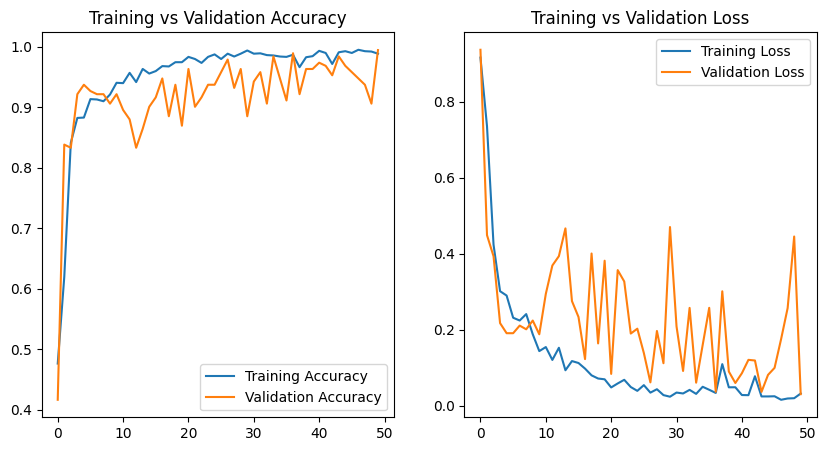

In [39]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training vs Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title("Training vs Validation Loss")

plt.show()

#### Run prediction on a sample image

First Image to predict
Actual Label: Potato___Late_blight
1/1 [==============================] - 0s 378ms/step
Predicted Label: Potato___Late_blight


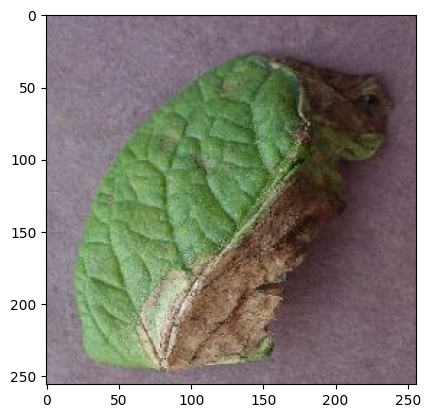

In [40]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    predicted_first_label = class_names[np.argmax(batch_prediction[0])]
    print("Predicted Label:", predicted_first_label)


#### Write a function for inference

In [41]:
def predict (model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #batching... 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

##### Now run inference on few sample images

1/1 [==============================] - 0s 29ms/step


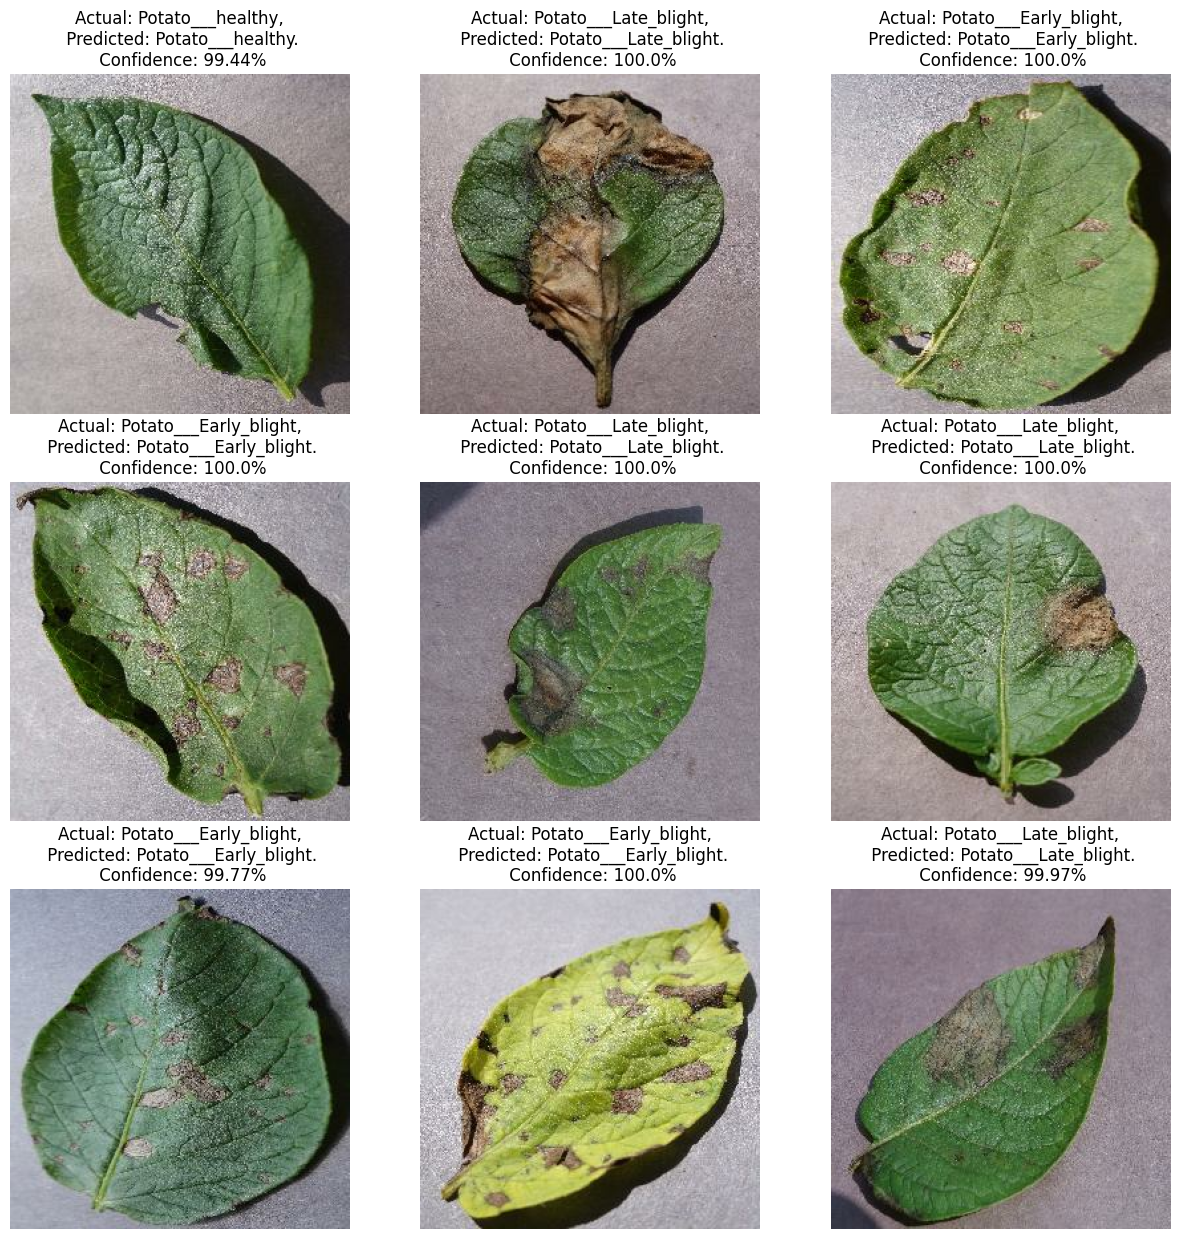

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model

We append the model to the list of models as a new version

In [43]:
# Manual Saving
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [44]:
# Dynamic Saving if we already created a folder called "models"
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [45]:
# Save the model in native Keras format
model.save('my_model.keras')